# Sionna Ray Tracing Tutorial: Rays Analyze

In this notebook, we demonstrate how to:

1. **Load and Preview** the existing scene
2. **Generate** random point and make sure they remain outside of the building.
3. **Configure** antenna for transmitters and receivers.
4. **Compute** path between the tx and rx point pairs.
5. **Visualize** the paths(rays) using Sionna pre-built functions
6. **Save** the raw rays information.
7. **Analyze** the rays information.


Make sure you have Sionna and its dependencies installed. For reference:
```console
pip install sionna
```


In [1]:
# Core imports
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

2025-02-15 20:13:33.313899: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-15 20:13:33.315398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 20:13:33.341572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 20:13:33.341591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 20:13:33.342341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## 1. **Load and Preview** the existing scene

We assume you have a 3D scene XML file generated with our command line tool `scenegen`, check the `README.md` of this repo for details. 

You can use the following controls:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move

In [2]:
# Load scene and access Mitsuba's internal representation
scene = load_scene("../scenes/Boston/scene.xml")

# Interactive 3D preview
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## 2. **Generate** random point and make sure they remain outside of the building.


1. Generate candidate positions within scene bounds
2. Filter out indoor positions using upward ray tracing.


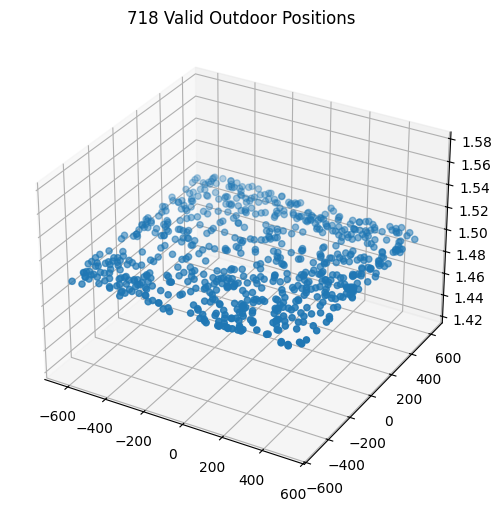

In [3]:

# Obtain the Mitsuba scene obejct from Sionna scene object 
mi_scene = scene.mi_scene

# Calculate scene bounding box excluding ground plane
bbox = mi.ScalarBoundingBox3f()
for shape in mi_scene.shapes():
    if "ground" not in shape.id():
        bbox.expand(shape.bbox())

# Generate candidate positions (1.5m height = typical UE height)
num_candidates = 1000
candidates = np.column_stack([
    np.random.uniform(bbox.min.x, bbox.max.x, num_candidates),
    np.random.uniform(bbox.min.y, bbox.max.y, num_candidates),
    np.full(num_candidates, 1.5)
])

# Create a direction vector pointing upwards (towards the sky) 
#  and tile it to match the number of positions
directions_np = np.tile(np.array([0, 0, 1]), (num_candidates, 1))

# Ray tracing validation
rays = mi.Ray3f(
    mi.Vector3f(candidates),
    mi.Vector3f(directions_np)
)
si = mi_scene.ray_intersect(rays)
valid_mask = ~si.is_valid()

# Filter and visualize
valid_positions = candidates[valid_mask]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2])
ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions")
plt.show()

## 3. **Configure** antenna for transmitters and receivers.

Next, we specify:
1. The **transmit** antenna array: In this example, a planar array with a single element and isotropic pattern.
2. The **receive** antenna array: Also a planar array with a single element but with dipole pattern here).

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`. And also randomly select 10 valid positions from the above step as the receiver positon.

### **Note: scene geographical coordinate system**
- Coordinate system: Scene center is (0,0,0), the flat gournd polygon z-axis is 0.
- Units: Meters

### **Note: Sionna Azimuth/Elevation Format**
Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the Sionna format. Check the code below for details.

In [4]:
# Array configurations

# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Random select 10 receivers form valid_positions (Outdoor positions)
for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=10, replace=False)]):
    rx = Receiver(
        name=f"rx{i}",
        position=pos,
        orientation=[0, 0, 0] 
    )
    scene.add(rx)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, 100],  # Elevated position
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]  # 210° azimuth tilt
)
scene.add(tx)


# Validate setup
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## 4. **Compute** path between the tx and rx point pairs.


- `max_depth=3` (maximum number of reflections/refractions/diffractions)
- `diffraction=True` to include diffraction effects.
- `scattering=True` to include scattering effects.
- `scat_keep_prob` Probability with which a scattered path is kept.
- `num_samples=int(1e6)` controlling how many rays are sampled (reduce if running out of memory).

**Note**:
Lower down the number of samples if you received out-of-memory error.

In [5]:
# Configure simulation parameters
scene.frequency = 3.66e9  # 3.66 GHz carrier
scene.synthetic_array = True  # Optimize for array calculations

# Perform ray tracing
paths = scene.compute_paths(
    max_depth=3,
    diffraction=True,
    scattering=True,
    scat_keep_prob=0.001,
    num_samples=1e6, 
)



## 5. **Visualize** the paths(rays) using Sionna pre-built functions

In [6]:
# Preview the scene with paths.
scene.preview(paths, show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## 6. **Save** the raw rays information.
- `a`: Complex path gain
- `tau`: Path delay
- `phi/theta`: Azimuth/elevation angles
- `type`: LoS/Reflected/Diffracted/Scattered

In [11]:
# Convert paths to analyzable format
ray_data = paths.to_dict()

# Create structured dataset
def create_ray_dataset(ray_dict, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }
    
    type_map = {0: "LoS", 1: "Reflected", 2: "Diffracted", 3: "Scattered"}
    

    a = ray_dict["a"].numpy().squeeze()
    tau = ray_dict["tau"].numpy().squeeze()
    types = ray_dict["types"].numpy().squeeze()
    mask = ray_dict["mask"].numpy().squeeze()
    phi_r = ray_dict["phi_r"].numpy().squeeze()
    phi_t = ray_dict["phi_t"].numpy().squeeze()
    theta_r = ray_dict["theta_r"].numpy().squeeze()
    theta_t = ray_dict["theta_t"].numpy().squeeze()
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        
        # Filter out the RX which have no rays related
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    dataset["type"].append(type_map[types[sub_idx]])
                    

                    dataset["a"].append(a[idx,sub_idx])
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["freq"].append(frequency)
                    # Store the list instead of np.array to avoid the space sepreator in csv
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
                    dataset["rx_id"].append(idx)

    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(ray_data, frequency=3.66e9)
df.head()

,freq,rx_id,type,phi_r,phi_t,theta_r,theta_t,a,tau,rx_coord
0,3.660000e+09,1,Diffracted,1.174883,0.301334,1.234682,1.091915,2.357109e-08-2.379327e- 08j,9.463846e-07,"[78.62733245451295, 611.8929335668686, 1.5]"
1,3.660000e+09,1,Diffracted,1.184072,-1.660729,1.348466,1.793127,1.147686e-07-1.121749e- 07j,0.000000e+00,"[78.62733245451295, 611.8929335668686, 1.5]"
2,3.660000e+09,1,Scattered,1.158547,0.250657,1.277077,1.233724,0.000000e+00+0.000000e+ 00j,8.874387e-07,"[78.62733245451295, 611.8929335668686, 1.5]"
3,3.660000e+09,1,Scattered,1.157331,0.247017,1.335248,1.418568,0.000000e+00+0.000000e+ 00j,8.332705e-07,"[78.62733245451295, 611.8929335668686, 1.5]"
4,3.660000e+09,1,Scattered,1.180986,0.355396,1.353024,1.458535,0.000000e+00+0.000000e+ 00j,8.629974e-07,"[78.62733245451295, 611.8929335668686, 1.5]"


## 7. **Analyze** the rays information.


[0. 1. 2. 3.]


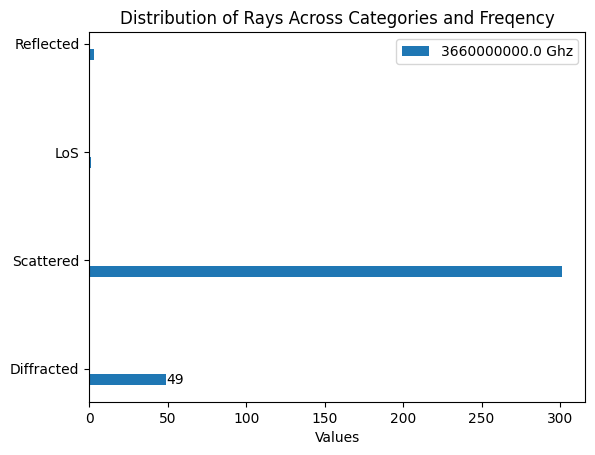

In [8]:
import matplotlib.pyplot as plt


# Get distinct values of ray types
distinct_types = df['type'].unique()

# Get distinct values of freq
distinct_freqs = df['freq'].unique()

values = []
for freq in distinct_freqs:
    tmp_value = []
    for ray_type in distinct_types:
        tmp_value.append(len( df.query("freq == {} and type == '{}'".format(freq, ray_type)) ))
    values.append(tmp_value)
values = np.array(values)


# Create an array for the positions of each group
group_positions = np.arange(len(distinct_types))

# Width of each bar
bar_width = 0.1

# Creating the horizontal bar chart
fig, ax = plt.subplots()

for i in range(len(distinct_freqs)):
    # Position of the bars on the x-axis
    positions = group_positions + i * bar_width
    print(positions)
    ax.barh(positions, values[i,:], height=bar_width, label="{} Ghz".format(distinct_freqs[i]))

# Adding labels
ax.set_yticks(group_positions + bar_width)
ax.set_yticklabels(distinct_types)
ax.set_xlabel('Values')
ax.set_title('Distribution of Rays Across Categories and Freqency')

# Adding value labels on top of the bars
for i in range(len(distinct_freqs)):
    for j in range(len(distinct_freqs)):
        ax.text(values[i, j], j + i * bar_width, str(values[i, j]), va='center')

# Adding legend
ax.legend()

# Adding legend with reversed order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Display the chart
plt.show()

### Path Gain Characteristics
CDF shows the distribution of received power across all paths

/home/test/miniconda3/envs/new_pipe/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


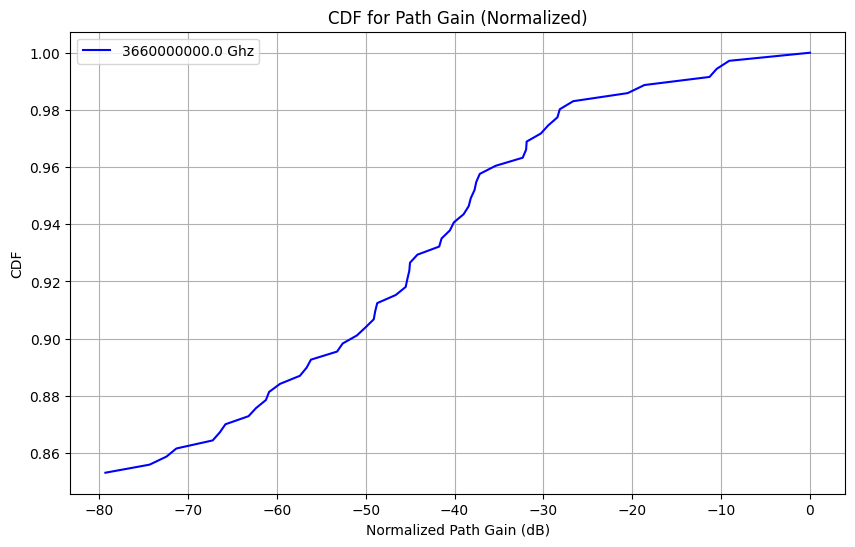

In [9]:
def multi_cdf(data_df, target_column, title,  x_label = 'Value', y_label = 'CDF', normalized=False):
    # Get distinct values of ray types
    distinct_types = df['type'].unique()
    
    # Get distinct values of freq
    distinct_freqs = df['freq'].unique()

    colors = ["blue","green", "red"]

    # Function to compute CDF
    def compute_cdf(data):
        if len(data) == 1:
            # Special case for single data point
            data_sorted = np.array([data[0], data[0]])
            cdf = np.array([0, 1])
        else:
            data_sorted = np.sort(data)
            cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        return data_sorted, cdf
    


    # Plotting the CDFs
    plt.figure(figsize=(10, 6))
    for i, freq in enumerate(distinct_freqs):
        tmp_df = data_df.query("freq == {} and type!= 3".format(freq))
        
        if normalized:
            tmp_df.loc[:,target_column] = tmp_df[target_column] - tmp_df[target_column].max()

        # Compute CDFs for each class
        tmp_x, tmp_cdf = compute_cdf( tmp_df[target_column].to_list())
        plt.plot(tmp_x, tmp_cdf, label="{} Ghz".format(freq), color=colors[i])
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()




# Path Gain
tmp_df = df[['freq', 'a', 'type']].copy()
tmp_df.loc[:,'pathGain'] = 20*np.log10(np.abs(tmp_df['a']))
multi_cdf(tmp_df, "pathGain", "CDF for Path Gain (Normalized)", "Normalized Path Gain (dB)", normalized = True)


Refer to [Sionna Documentation](https://nvlabs.github.io/sionna/) for advanced features!